In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys
import pickle
import numpy as np
import os
import scipy.sparse as sp
from scipy.sparse import linalg
import pandas as pd
import torch.optim as optim
import time
import matplotlib.pyplot as plt

In [2]:
class nconv(nn.Module):
    def __init__(self):
        super(nconv,self).__init__()

    def forward(self,x, A):
        x = torch.einsum('ncvl,vw->ncwl',(x,A))
        return x.contiguous()

In [3]:
class linear(nn.Module):
    def __init__(self,c_in,c_out):
        super(linear,self).__init__()
        self.mlp = nn.Conv2d(c_in, c_out, kernel_size=(1, 1), bias=True)

    def forward(self,x):
        return self.mlp(x)

In [4]:
class gcn(nn.Module):
    def __init__(self,c_in,c_out,dropout,support_len=3,order=2):
        super(gcn,self).__init__()
        self.nconv = nconv()
        c_in = (order*support_len+1)*c_in
        self.mlp = linear(c_in,c_out)
        self.dropout = dropout
        self.order = order

    def forward(self,x,support):
        out = [x]
        for a in support:
            x1 = self.nconv(x,a)
            out.append(x1)
            for k in range(2, self.order + 1):
                x2 = self.nconv(x1,a)
                out.append(x2)
                x1 = x2

        h = torch.cat(out,dim=1)
        h = self.mlp(h)
        h = F.dropout(h, self.dropout, training=self.training)
        return h

In [5]:
class gwnet(nn.Module):
    def __init__(
        self, device, num_nodes,
        dropout=0.3, supports=None, gcn_bool=True,
        addaptadj=True, aptinit=None,
        in_dim=2, out_dim=12,
        residual_channels=32, dilation_channels=32,
        skip_channels=256, end_channels=512,
        kernel_size=2, blocks=4, layers=2
    ):
        super(gwnet, self).__init__()
        self.dropout = dropout
        self.blocks = blocks
        self.layers = layers
        self.gcn_bool = gcn_bool
        self.addaptadj = addaptadj

        # initial 1x1 conv
        self.start_conv = nn.Conv2d(in_dim, residual_channels, kernel_size=(1,1))
        self.supports = supports or []

        # build layers
        receptive_field = 1
        self.supports_len = len(self.supports)

        # adaptive adj init
        if gcn_bool and addaptadj:
            if aptinit is None:
                self.nodevec1 = nn.Parameter(torch.randn(num_nodes,10).to(device))
                self.nodevec2 = nn.Parameter(torch.randn(10,num_nodes).to(device))
            else:
                m,p,n = torch.svd(aptinit)
                self.nodevec1 = nn.Parameter((m[:,:10]@torch.diag(p[:10]**0.5)).to(device))
                self.nodevec2 = nn.Parameter((torch.diag(p[:10]**0.5)@n[:,:10].t()).to(device))
            self.supports_len += 1

        self.filter_convs = nn.ModuleList()
        self.gate_convs   = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs   = nn.ModuleList()
        self.bn           = nn.ModuleList()
        self.gconv        = nn.ModuleList()

        for b in range(blocks):
            new_dilation = 1
            for _ in range(layers):
                # dilated convs: both filter and gate using Conv2d
                self.filter_convs.append(
                    nn.Conv2d(residual_channels, dilation_channels, kernel_size=(1,kernel_size), dilation=(1,new_dilation))
                )
                self.gate_convs.append(
                    nn.Conv2d(residual_channels, dilation_channels, kernel_size=(1,kernel_size), dilation=(1,new_dilation))
                )
                # 1x1 residual & skip
                self.residual_convs.append(
                    nn.Conv2d(dilation_channels, residual_channels, kernel_size=(1,1))
                )
                self.skip_convs.append(
                    nn.Conv2d(dilation_channels, skip_channels, kernel_size=(1,1))
                )
                self.bn.append(nn.BatchNorm2d(residual_channels))
                if gcn_bool:
                    self.gconv.append(
                        gcn(dilation_channels, residual_channels, dropout, support_len=self.supports_len)
                    )
                receptive_field += (kernel_size-1)*new_dilation
                new_dilation *= 2

        self.end_conv_1 = nn.Conv2d(skip_channels, end_channels, kernel_size=(1,1))
        self.end_conv_2 = nn.Conv2d(end_channels, out_dim,      kernel_size=(1,1))
        self.receptive_field = receptive_field

    def forward(self, input):
        B, C, N, T = input.shape
        if T < self.receptive_field:
            input = F.pad(input, (self.receptive_field-T,0,0,0))
        x = self.start_conv(input)
        skip = torch.zeros(B, self.skip_convs[0].out_channels, N, x.size(3), device=x.device)

        # compute adaptive supports
        new_supports = list(self.supports)
        if self.gcn_bool and self.addaptadj:
            adp = F.softmax(F.relu(self.nodevec1 @ self.nodevec2), dim=1)
            new_supports.append(adp)

        for i in range(self.blocks * self.layers):
            residual = x
            f = torch.tanh(self.filter_convs[i](residual))
            g = torch.sigmoid(self.gate_convs[i](residual))
            x = f * g
            s = self.skip_convs[i](x)
            skip = skip[..., -s.size(3):] + s
            if self.gcn_bool:
                x = self.gconv[i](x, new_supports)
            else:
                x = self.residual_convs[i](x)
            x = x + residual[..., -x.size(3):]
            x = self.bn[i](x)

        x = F.relu(skip)
        x = F.relu(self.end_conv_1(x))
        x = self.end_conv_2(x)
        return x

In [6]:
class DataLoader(object):
    def __init__(self, xs, ys, batch_size, pad_with_last_sample=True):
        """
        :param xs:
        :param ys:
        :param batch_size:
        :param pad_with_last_sample: pad with the last sample to make number of samples divisible to batch_size.
        """
        self.batch_size = batch_size
        self.current_ind = 0
        if pad_with_last_sample:
            num_padding = (batch_size - (len(xs) % batch_size)) % batch_size
            x_padding = np.repeat(xs[-1:], num_padding, axis=0)
            y_padding = np.repeat(ys[-1:], num_padding, axis=0)
            xs = np.concatenate([xs, x_padding], axis=0)
            ys = np.concatenate([ys, y_padding], axis=0)
        self.size = len(xs)
        self.num_batch = int(self.size // self.batch_size)
        self.xs = xs
        self.ys = ys

    def shuffle(self):
        permutation = np.random.permutation(self.size)
        xs, ys = self.xs[permutation], self.ys[permutation]
        self.xs = xs
        self.ys = ys

    def get_iterator(self):
        self.current_ind = 0

        def _wrapper():
            while self.current_ind < self.num_batch:
                start_ind = self.batch_size * self.current_ind
                end_ind = min(self.size, self.batch_size * (self.current_ind + 1))
                x_i = self.xs[start_ind: end_ind, ...]
                y_i = self.ys[start_ind: end_ind, ...]
                yield (x_i, y_i)
                self.current_ind += 1

        return _wrapper()

In [7]:
class StandardScaler():
    """
    Standard the input
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean

In [8]:
def sym_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).astype(np.float32).todense()

def asym_adj(adj):
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv = np.power(rowsum, -1).flatten()
    d_inv[np.isinf(d_inv)] = 0.
    d_mat= sp.diags(d_inv)
    return d_mat.dot(adj).astype(np.float32).todense()

In [9]:
def calculate_normalized_laplacian(adj):
    """
    # L = D^-1/2 (D-A) D^-1/2 = I - D^-1/2 A D^-1/2
    # D = diag(A 1)
    :param adj:
    :return:
    """
    adj = sp.coo_matrix(adj)
    d = np.array(adj.sum(1))
    d_inv_sqrt = np.power(d, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    normalized_laplacian = sp.eye(adj.shape[0]) - adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
    return normalized_laplacian

def calculate_scaled_laplacian(adj_mx, lambda_max=2, undirected=True):
    if undirected:
        adj_mx = np.maximum.reduce([adj_mx, adj_mx.T])
    L = calculate_normalized_laplacian(adj_mx)
    if lambda_max is None:
        lambda_max, _ = linalg.eigsh(L, 1, which='LM')
        lambda_max = lambda_max[0]
    L = sp.csr_matrix(L)
    M, _ = L.shape
    I = sp.identity(M, format='csr', dtype=L.dtype)
    L = (2 / lambda_max * L) - I
    return L.astype(np.float32).todense()

In [10]:
def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data

In [11]:
def load_dataset(dataset_dir, batch_size, valid_batch_size= None, test_batch_size=None):
    data = {}
    for category in ['train', 'val', 'test']:
        cat_data = np.load(os.path.join(dataset_dir, category + '.npz'))
        data['x_' + category] = cat_data['x']
        data['y_' + category] = cat_data['y']
    scaler = StandardScaler(mean=data['x_train'][..., 0].mean(), std=data['x_train'][..., 0].std())
    # Data format
    for category in ['train', 'val', 'test']:
        data['x_' + category][..., 0] = scaler.transform(data['x_' + category][..., 0])
    data['train_loader'] = DataLoader(data['x_train'], data['y_train'], batch_size)
    data['val_loader'] = DataLoader(data['x_val'], data['y_val'], valid_batch_size)
    data['test_loader'] = DataLoader(data['x_test'], data['y_test'], test_batch_size)
    data['scaler'] = scaler
    return data

In [12]:
def load_adj(pkl_filename, adjtype):
    sensor_ids, sensor_id_to_ind, adj_mx = load_pickle(pkl_filename)
    if adjtype == "scalap":
        adj = [calculate_scaled_laplacian(adj_mx)]
    elif adjtype == "normlap":
        adj = [calculate_normalized_laplacian(adj_mx).astype(np.float32).todense()]
    elif adjtype == "symnadj":
        adj = [sym_adj(adj_mx)]
    elif adjtype == "transition":
        adj = [asym_adj(adj_mx)]
    elif adjtype == "doubletransition":
        adj = [asym_adj(adj_mx), asym_adj(np.transpose(adj_mx))]
    elif adjtype == "identity":
        adj = [np.diag(np.ones(adj_mx.shape[0])).astype(np.float32)]
    else:
        error = 0
        assert error, "adj type not defined"
    return sensor_ids, sensor_id_to_ind, adj

In [13]:
def masked_mse(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels!=null_val)
    mask = mask.float()
    mask /= torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = (preds-labels)**2
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)

def masked_rmse(preds, labels, null_val=np.nan):
    return torch.sqrt(masked_mse(preds=preds, labels=labels, null_val=null_val))


def masked_mae(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels!=null_val)
    mask = mask.float()
    mask /=  torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds-labels)
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)


def masked_mape(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels!=null_val)
    mask = mask.float()
    mask /=  torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds-labels)/labels
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)


def metric(pred, real):
    mae = masked_mae(pred,real,0.0).item()
    mape = masked_mape(pred,real,0.0).item()
    rmse = masked_rmse(pred,real,0.0).item()
    return mae,mape,rmse

In [14]:
def generate_graph_seq2seq_io_data(
        df, x_offsets, y_offsets, add_time_in_day=True, add_day_in_week=False, scaler=None
):
    """
    Generate samples from
    :param df:
    :param x_offsets:
    :param y_offsets:
    :param add_time_in_day:
    :param add_day_in_week:
    :param scaler:
    :return:
    # x: (epoch_size, input_length, num_nodes, input_dim)
    # y: (epoch_size, output_length, num_nodes, output_dim)
    """

    num_samples, num_nodes = df.shape
    data = np.expand_dims(df.values, axis=-1)
    feature_list = [data]
    if add_time_in_day:
        time_ind = (df.index.values - df.index.values.astype("datetime64[D]")) / np.timedelta64(1, "D")
        time_in_day = np.tile(time_ind, [1, num_nodes, 1]).transpose((2, 1, 0))
        feature_list.append(time_in_day)
    if add_day_in_week:
        dow = df.index.dayofweek
        dow_tiled = np.tile(dow, [1, num_nodes, 1]).transpose((2, 1, 0))
        feature_list.append(dow_tiled)

    data = np.concatenate(feature_list, axis=-1)
    x, y = [], []
    min_t = abs(min(x_offsets))
    max_t = abs(num_samples - abs(max(y_offsets)))  # Exclusive
    for t in range(min_t, max_t):  # t is the index of the last observation.
        x.append(data[t + x_offsets, ...])
        y.append(data[t + y_offsets, ...])
    x = np.stack(x, axis=0)
    y = np.stack(y, axis=0)
    return x, y

In [15]:
def generate_train_val_test(args):
    seq_length_x, seq_length_y = args.seq_length_x, args.seq_length_y
    df = pd.read_hdf(args.traffic_df_filename)
    # 0 is the latest observed sample.
    x_offsets = np.sort(np.concatenate((np.arange(-(seq_length_x - 1), 1, 1),)))
    # Predict the next one hour
    y_offsets = np.sort(np.arange(args.y_start, (seq_length_y + 1), 1))
    # x: (num_samples, input_length, num_nodes, input_dim)
    # y: (num_samples, output_length, num_nodes, output_dim)
    x, y = generate_graph_seq2seq_io_data(
        df,
        x_offsets=x_offsets,
        y_offsets=y_offsets,
        add_time_in_day=True,
        add_day_in_week=args.dow,
    )

    print("x shape: ", x.shape, ", y shape: ", y.shape)
    # Write the data into npz file.
    num_samples = x.shape[0]
    num_test = round(num_samples * 0.2)
    num_train = round(num_samples * 0.7)
    num_val = num_samples - num_test - num_train
    x_train, y_train = x[:num_train], y[:num_train]
    x_val, y_val = (
        x[num_train: num_train + num_val],
        y[num_train: num_train + num_val],
    )
    x_test, y_test = x[-num_test:], y[-num_test:]

    for cat in ["train", "val", "test"]:
        _x, _y = locals()["x_" + cat], locals()["y_" + cat]
        print(cat, "x: ", _x.shape, "y:", _y.shape)
        np.savez_compressed(
            os.path.join(args.output_dir, f"{cat}.npz"),
            x=_x,
            y=_y,
            x_offsets=x_offsets.reshape(list(x_offsets.shape) + [1]),
            y_offsets=y_offsets.reshape(list(y_offsets.shape) + [1]),
        )

In [16]:
class trainer():
    def __init__(self, scaler, in_dim, seq_length, num_nodes, nhid , dropout, lrate, wdecay, device, supports, gcn_bool, addaptadj, aptinit):
        self.model = gwnet(device, num_nodes, dropout, supports=supports, gcn_bool=gcn_bool, addaptadj=addaptadj, aptinit=aptinit, in_dim=in_dim, out_dim=seq_length, residual_channels=nhid, dilation_channels=nhid, skip_channels=nhid * 8, end_channels=nhid * 16)
        self.model.to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lrate, weight_decay=wdecay)
        self.loss = masked_mae
        self.scaler = scaler
        self.clip = 5

    def train(self, input, real_val):
        self.model.train()
        self.optimizer.zero_grad()
        input = nn.functional.pad(input,(1,0,0,0))
        output = self.model(input)
        output = output.transpose(1,3)
        #output = [batch_size,12,num_nodes,1]
        real = torch.unsqueeze(real_val,dim=1)
        predict = self.scaler.inverse_transform(output)

        loss = self.loss(predict, real, 0.0)
        loss.backward()
        if self.clip is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip)
        self.optimizer.step()
        mape = masked_mape(predict,real,0.0).item()
        rmse = masked_rmse(predict,real,0.0).item()
        return loss.item(),mape,rmse

    def eval(self, input, real_val):
        self.model.eval()
        input = nn.functional.pad(input,(1,0,0,0))
        output = self.model(input)
        output = output.transpose(1,3)
        #output = [batch_size,12,num_nodes,1]
        real = torch.unsqueeze(real_val,dim=1)
        predict = self.scaler.inverse_transform(output)
        loss = self.loss(predict, real, 0.0)
        mape = masked_mape(predict,real,0.0).item()
        rmse = masked_rmse(predict,real,0.0).item()
        return loss.item(),mape,rmse

In [17]:
def load_metr_la_data_loaders(
    h5_file: str,
    seq_length_x: int = 12,
    seq_length_y: int = 12,
    y_start: int = 1,
    add_day_in_week: bool = False,
    batch_size: int = 64,
    valid_batch_size: int = None,
    test_batch_size: int = None
) -> tuple:
    """
    Returns (train_loader, val_loader, test_loader, scaler, x_offsets, y_offsets)
    """
    df = pd.read_hdf(h5_file)
    x_offsets = np.arange(-(seq_length_x - 1), 1, 1)
    y_offsets = np.arange(y_start, seq_length_y + 1, 1)
    x_all, y_all = generate_graph_seq2seq_io_data(
        df, x_offsets, y_offsets,
        add_time_in_day=True,
        add_day_in_week=add_day_in_week
    )
    n = x_all.shape[0]
    n_test = int(n * 0.2)
    n_train = int(n * 0.7)
    n_val = n - n_train - n_test

    x_train, y_train = x_all[:n_train], y_all[:n_train]
    x_val,   y_val   = x_all[n_train:n_train+n_val], y_all[n_train:n_train+n_val]
    x_test,  y_test  = x_all[-n_test:], y_all[-n_test:]

    scaler = StandardScaler(mean=x_train[...,0].mean(), std=x_train[...,0].std())
    for arr in (x_train, x_val, x_test):
        arr[...,0] = scaler.transform(arr[...,0])

    valid_batch_size = valid_batch_size or batch_size
    test_batch_size  = test_batch_size  or batch_size

    train_loader = DataLoader(x_train, y_train, batch_size)
    val_loader   = DataLoader(x_val,   y_val,   valid_batch_size)
    test_loader  = DataLoader(x_test,  y_test,  test_batch_size)

    return train_loader, val_loader, test_loader, scaler, x_offsets, y_offsets

In [18]:
config = {
    'h5_file':             '/kaggle/input/metr-la-dataset/METR-LA.h5',
    'adj_pkl':             '/kaggle/input/metr-la-dataset/adj_METR-LA.pkl',
    'adj_type':            'doubletransition',
    'seq_length_x':        12,
    'seq_length_y':        12,
    'y_start':             1,
    'add_day_in_week':     True,
    'batch_size':          64,
    # 'in_dim':              2,
    'nhid':                32,
    'dropout':             0.3,
    'learning_rate':       1e-3,
    'weight_decay':        1e-4,
    'epochs':              100,
    'device':             'cuda:0',
    'gcn_bool':            True,
    'aptonly':             False,
    'addaptadj':           True,
    'randomadj':           False,
    'save_dir':           './garage/metr',
    'expid':               1,
    'print_every':         50,
    'plot_heatmap':        True,
    'wave_nodes':          [99],
}

In [19]:
train_loader, val_loader, test_loader, scaler, x_offsets, y_offsets = \
    load_metr_la_data_loaders(
        config['h5_file'],
        config['seq_length_x'],
        config['seq_length_y'],
        config['y_start'],
        config['add_day_in_week'],
        config['batch_size']
    )
in_dim = train_loader.xs.shape[-1]

In [20]:
sensor_ids, sensor_id_to_ind, adj_mx = load_adj(
    config['adj_pkl'], config['adj_type']
)
supports = [torch.tensor(a).to(config['device']) for a in adj_mx]
adjinit  = None if config['randomadj'] else supports[0]
if config['aptonly']:
    supports = None

In [21]:
engine = trainer(
    scaler,
    train_loader.xs.shape[-1],
    config['seq_length_x'],
    len(sensor_ids),
    config['nhid'],
    config['dropout'],
    config['learning_rate'],
    config['weight_decay'],
    config['device'],
    supports,
    config['gcn_bool'],
    config['addaptadj'],
    adjinit
)
model = engine.model
os.makedirs(config['save_dir'], exist_ok=True)

In [22]:
history = {'train_loss': [], 'val_loss': []}
best_val = float('inf')
best_model_path = None
for epoch in range(1, config['epochs']+1):
    t0 = time.time()
    # Training
    train_loader.shuffle()
    losses, mapes, rmses = [], [], []
    for i, (x, y) in enumerate(train_loader.get_iterator()):
        x_t = torch.Tensor(x).to(config['device']).transpose(1,3)
        y_t = torch.Tensor(y).to(config['device']).transpose(1,3)[:,0,:,:]
        loss, mape, rmse = engine.train(x_t, y_t)
        losses.append(loss); mapes.append(mape); rmses.append(rmse)
        if i % config['print_every'] == 0:
            mse = loss**2
            print(f"Epoch {epoch:03d} | Iter {i:03d} | MAE {loss:.4f} | MSE {mse:.4f} | RMSE {rmse:.4f} | MAPE {mape:.4f}")
    avg_train = np.mean(losses)
    avg_mape_train = np.mean(mapes)
    avg_rmse_train = np.mean(rmses)
    avg_mse_train = avg_train**2
    history['train_loss'].append(avg_train)
    print(f"Epoch {epoch:03d} training completed in {time.time()-t0:.1f}s | Avg MAE {avg_train:.4f} | Avg MSE {avg_mse_train:.4f} | Avg RMSE {avg_rmse_train:.4f} | Avg MAPE {avg_mape_train:.4f}")
    # Validation
    val_losses, val_mapes, val_rmses = [], [], []
    for x, y in val_loader.get_iterator():
        x_v = torch.Tensor(x).to(config['device']).transpose(1,3)
        y_v = torch.Tensor(y).to(config['device']).transpose(1,3)[:,0,:,:]
        l, m, r = engine.eval(x_v, y_v)
        val_losses.append(l); val_mapes.append(m); val_rmses.append(r)
    avg_val = np.mean(val_losses)
    avg_mape_val = np.mean(val_mapes)
    avg_rmse_val = np.mean(val_rmses)
    avg_mse_val = avg_val**2
    history['val_loss'].append(avg_val)
    print(f"Epoch {epoch:03d} | Val MAE {avg_val:.4f} | Val MSE {avg_mse_val:.4f} | Val RMSE {avg_rmse_val:.4f} | Val MAPE {avg_mape_val:.4f}")
    # Save best
    if avg_val < best_val:
        best_val = avg_val
        best_model_path = os.path.join(config['save_dir'], f"metr_la_exp{config['expid']}_best.pth")
        os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model at epoch {epoch} to {best_model_path}")

Epoch 001 | Iter 000 | MAE 11.8314 | MSE 139.9811 | RMSE 14.2691 | MAPE 0.3179
Epoch 001 | Iter 050 | MAE 4.9157 | MSE 24.1643 | RMSE 9.3824 | MAPE 0.1428
Epoch 001 | Iter 100 | MAE 4.0802 | MSE 16.6481 | RMSE 7.8140 | MAPE 0.1066
Epoch 001 | Iter 150 | MAE 3.6549 | MSE 13.3586 | RMSE 6.7938 | MAPE 0.0962
Epoch 001 | Iter 200 | MAE 4.8888 | MSE 23.9003 | RMSE 9.0796 | MAPE 0.1578
Epoch 001 | Iter 250 | MAE 4.1006 | MSE 16.8152 | RMSE 8.2216 | MAPE 0.1179
Epoch 001 | Iter 300 | MAE 4.0472 | MSE 16.3801 | RMSE 7.9638 | MAPE 0.1218
Epoch 001 | Iter 350 | MAE 3.5976 | MSE 12.9430 | RMSE 7.1535 | MAPE 0.0960
Epoch 001 training completed in 45.3s | Avg MAE 4.1410 | Avg MSE 17.1481 | Avg RMSE 7.8705 | Avg MAPE 0.1157
Epoch 001 | Val MAE 3.5422 | Val MSE 12.5471 | Val RMSE 6.6571 | Val MAPE 0.1001
Saved best model at epoch 1 to ./garage/metr/metr_la_exp1_best.pth
Epoch 002 | Iter 000 | MAE 3.9238 | MSE 15.3962 | RMSE 7.6150 | MAPE 0.1048
Epoch 002 | Iter 050 | MAE 3.4780 | MSE 12.0963 | RMSE 6

Text(0.5, 1.0, 'Training & Validation Loss')

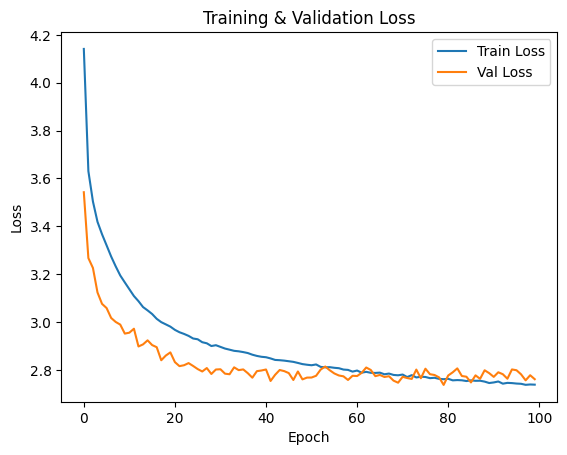

In [23]:
plt.figure()
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

In [24]:
print("\nLoading best model for testing...")
model.load_state_dict(torch.load(best_model_path))
model.eval()

realy = torch.Tensor(test_loader.ys).to(config['device']).transpose(1,3)[:,0,:,:]
outputs = []
for x, y in test_loader.get_iterator():
    x_t = torch.Tensor(x).to(config['device']).transpose(1,3)
    with torch.no_grad():
        preds = engine.model(x_t).transpose(1,3).squeeze(1)
    outputs.append(preds)

yhat = torch.cat(outputs, dim=0)[:realy.size(0)]
# Metrics per horizon
for h in range(yhat.shape[2]):
    pred_h = scaler.inverse_transform(yhat[:,:,h].cpu().numpy())
    real_h = realy[:,:,h].cpu().numpy()
    pred_h = torch.tensor(pred_h)
    real_h = torch.tensor(real_h)
    m1, m2, m3 = metric(pred_h, real_h)
    print(f"Horizon {h+1:02d} | MAE {m1:.4f} | MAPE {m2:.4f} | RMSE {m3:.4f}")
# Overall
all_mae = [metric(torch.tensor(scaler.inverse_transform(yhat[:,:,h].cpu().numpy())), torch.tensor(realy[:,:,h].cpu().numpy())[0]) for h in range(yhat.shape[2])]
print(f"Overall MAE: {np.mean(all_mae):.4f}")


Loading best model for testing...


/tmp/ipykernel_19/1424786751.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Horizon 01 | MAE 2.2247 | MAPE 0.0536 | RMSE 3.8489
Horizon 02 | MAE 2.4912 | MAPE 0.0624 | RMSE 4.6097
Horizon 03 | MAE 2.6724 | MAPE 0.0690 | RMSE 5.1193
Horizon 04 | MAE 2.8174 | MAPE 0.0745 | RMSE 5.5166
Horizon 05 | MAE 2.9296 | MAPE 0.0790 | RMSE 5.8410
Horizon 06 | MAE 3.0424 | MAPE 0.0835 | RMSE 6.1178
Horizon 07 | MAE 3.1180 | MAPE 0.0867 | RMSE 6.3387
Horizon 08 | MAE 3.1950 | MAPE 0.0900 | RMSE 6.5465
Horizon 09 | MAE 3.2661 | MAPE 0.0926 | RMSE 6.7321
Horizon 10 | MAE 3.3237 | MAPE 0.0950 | RMSE 6.8868
Horizon 11 | MAE 3.3820 | MAPE 0.0972 | RMSE 7.0312
Horizon 12 | MAE 3.4381 | MAPE 0.0996 | RMSE 7.1691
Overall MAE: 6.7089


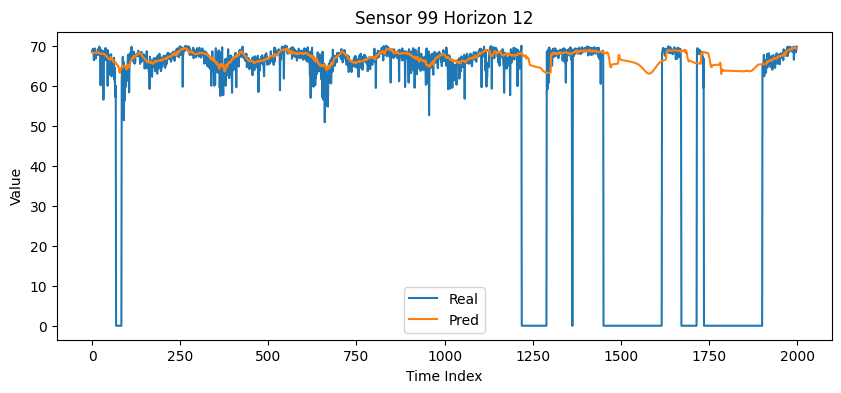

In [25]:
# if config['plot_heatmap']:
#     adp = torch.softmax(F.relu(model.nodevec1 @ model.nodevec2), dim=1).cpu().detach().numpy()
#     sns.heatmap(pd.DataFrame(adp))
#     plt.title('Learned Adjacency Heatmap')
#     plt.savefig(os.path.join(config['save_dir'], 'adj_heatmap.png'))

# --- Wave CSV & Plots ---
wave_data = {}
for node in config['wave_nodes']:
    real_vals = realy[:, node, -1].cpu().numpy()
    pred_vals = scaler.inverse_transform(yhat[:, node, -1].cpu().numpy())
    wave_data[f'real_{node}'] = real_vals
    wave_data[f'pred_{node}'] = pred_vals
# Save CSV
pd.DataFrame(wave_data).to_csv(os.path.join(config['save_dir'], 'wave.csv'), index=False)
# Plot sample
plt.figure(figsize=(10,4))
plt.plot(wave_data[f"real_{config['wave_nodes'][0]}"][2200:4200], label='Real')
plt.plot(wave_data[f"pred_{config['wave_nodes'][0]}"][2200:4200], label='Pred')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.title(f"Sensor {config['wave_nodes'][0]} Horizon {config['seq_length_y']}")
plt.legend()
# plt.savefig(os.path.join(config['save_dir'], 'wave_plot.png'))